# MTL SegNet
- Implementing SegNet for multi-task learning and benchmarking on NYUv2 and CityScapes
- Simple and hopefully elegant compositional OO design
- Only naive MTL is used, no loss or gradient weighting
- Purpose is the analysis of the architecture in basic settings
- Data, metrics and losses taken from https://github.com/lorenmt/auto-lambda/
- Ablations on model variations: dedicated/shared decoders; varying the number of filters in layers


# 1. Data
- NYUv2: train [288x384], val [288x384]
    - RGB (3 channels)
    - Semantic Segmentation 13 classes (1 channels)
    - Depth Esitmation (1 channels)
    - Surface Normal Prediction (3 channels)
- CityScapes train [256x256], val [256x512]
    - RGB (3 channels)
    - Semantic Segmentation 19 classes (1 channels)
    - Part Segmentation 10 classes (1 channels)
    - Disparity (inv Depth) Estimation (1 channels)

In [1]:
import os
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append(os.path.expanduser("~") + "/work/libs/auto-lambda/")
from create_dataset import NYUv2, CityScapes

ds_root = "/data/datasets/"


def get_loaders(dataset="nyuv2", batch_size=4, augmentation=True):
    assert dataset in ["nyuv2", "cityscapes"]
    ds = "NYUv2_mtan" if dataset == "nyuv2" else "cityscapes_mtan"
    ds_root = f"/data/datasets/{ds}"
    ds_cls = NYUv2 if dataset == "nyuv2" else CityScapes

    train_ds = ds_cls(root=ds_root, train=True, augmentation=augmentation)
    test_ds = ds_cls(root=ds_root, train=False)

    train_loader = torch.utils.data.DataLoader(
        dataset=train_ds, batch_size=batch_size, shuffle=True, num_workers=4
    )

    test_loader = torch.utils.data.DataLoader(
        dataset=test_ds, batch_size=batch_size, shuffle=False, num_workers=4
    )
    return train_loader, test_loader


def imshow(imgs, title=""):
    imgs[1]["rgb"] = imgs[0]
    imgs[1].pop("noise")
    f, axarr = plt.subplots(1, len(imgs[1]), figsize=(30, 5))
    f.suptitle(title)

    for i, (task, img) in enumerate(imgs[1].items()):
        axarr[i].set_title(f"{task} - {list(img.shape)}")
        if len(img.shape) == 2:
            img = img.unsqueeze(0)
        # normalise for plotting
        img = (img - img.min()) / (img.max() - img.min())
        axarr[i].imshow(img.permute(1, 2, 0))
    plt.show()


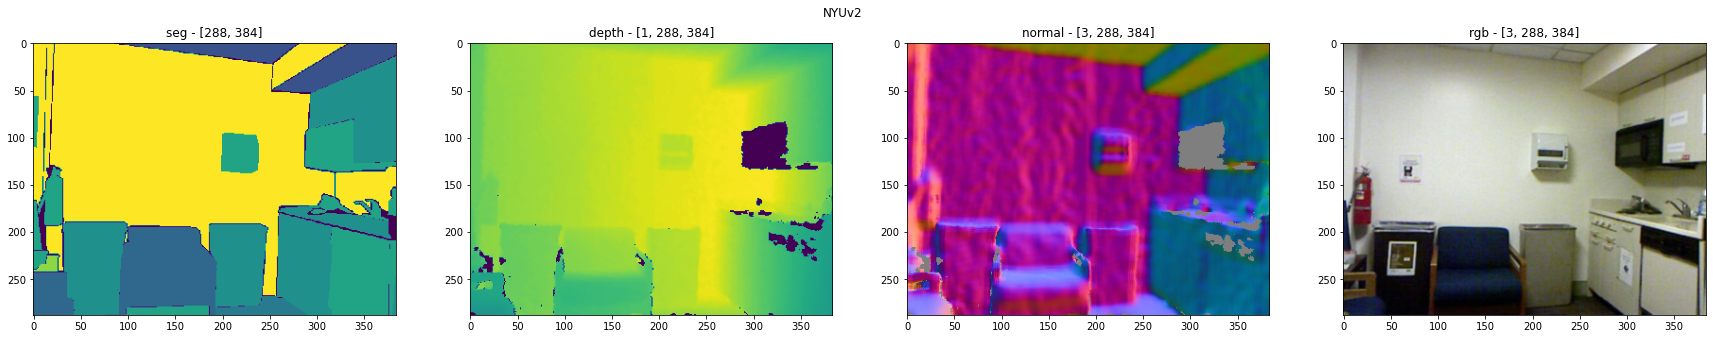

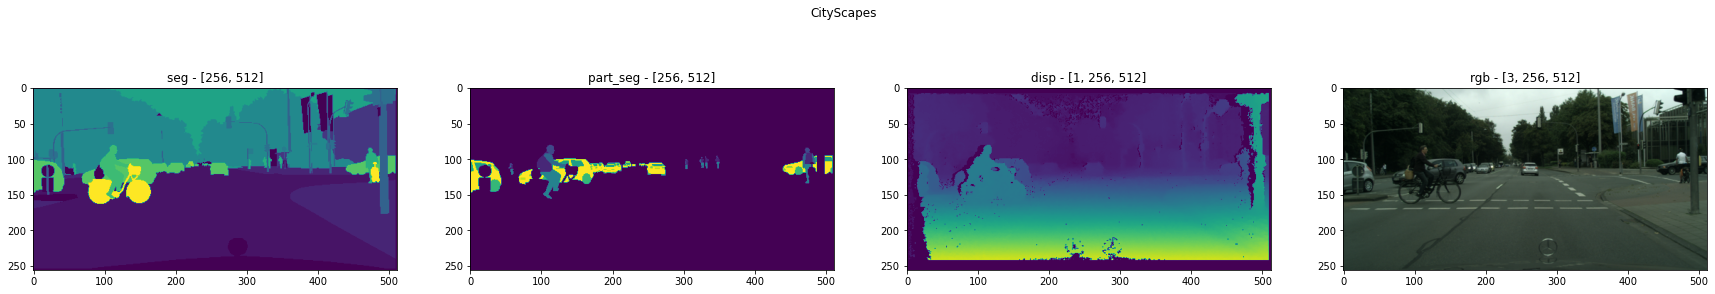

In [2]:
imshow(get_loaders(dataset="nyuv2")[1].dataset[0], title="NYUv2")

imshow(get_loaders(dataset="cityscapes")[1].dataset[0], title="CityScapes")


# 2. SegNet for Multi-task Learning

- VGG backbone (encoder) and mirrored decoder
- Need to keep indices from max pooling to reverse in the decoder
- Hierarchical (composition) class structure: ConvBNRelu, Blocks, Encoder/Decoder, MTLSegnet
- This implementation produces a model equivalent to the baseline in the MTAN paper in terms of parameters and order of computation https://github.com/lorenmt/mtan. It is worth noting that this has several differences to the original SegNet and the implementation used in prior MTL papers like Uncertainty Weighting.
- Added a hyper-param 'shared decoder': If each task should have its own dedicated decoder
- Added a hyper-param 'width_mul': Like in MobileNets where one can adjust the number of filters for each layer

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List
from collections import OrderedDict



class ConvBNReLU(nn.Sequential):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int):
        layers = [
            (
                "conv",
                nn.Conv2d(
                    in_channels, out_channels, kernel_size, padding=kernel_size // 2
                ),
            ),
            ("bn", nn.BatchNorm2d(out_channels)),
            ("relu", nn.ReLU(inplace=True)),
        ]
        super().__init__(OrderedDict(layers))

    @classmethod
    def Sequential(
        cls, in_channels: int, out_channels: List[int], kernel_size: int = 3
    ):
        """ Not kosher factory for sequential of several ConvBNReLUs """
        layers = []
        for out_channels_ in out_channels:
            layers.append(cls(in_channels, out_channels_, kernel_size=kernel_size))
            in_channels = out_channels_
        return nn.Sequential(*layers)


class EncoderBlock(nn.Sequential):
    def __init__(self, in_channels: int, out_channels: List[int]):
        convs = ConvBNReLU.Sequential(in_channels, out_channels, kernel_size=3)
        pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        super().__init__(*convs, pool)


class DecoderBlock(nn.Sequential):
    def __init__(self, in_channels: int, out_channels: List[int]):
        convs = ConvBNReLU.Sequential(in_channels, out_channels, kernel_size=3)
        pool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        super().__init__(pool, *convs)

    def forward(self, X, indices):
        res = self[0](X, indices)
        for layer_ix in range(1, len(self)):
            res = self[layer_ix](res)
        return res


class Encoder(nn.Sequential):
    def __init__(self, in_channels: int, block_channels: List[list]):
        blocks = []
        for out_channels in block_channels:
            blocks.append(EncoderBlock(in_channels, out_channels))
            in_channels = out_channels[-1]
        super().__init__(*blocks)

    def forward(self, X):
        indices = []
        for block in self:
            X, indices_ = block(X)
            indices.append(indices_)
        return X, indices


class Decoder(nn.Sequential):
    def __init__(self, in_channels: int, block_channels: List[list]):
        blocks = []
        for out_channels in block_channels:
            blocks.append(DecoderBlock(in_channels, out_channels))
            in_channels = out_channels[-1]
        super().__init__(*blocks)

    def forward(self, X, indices: list):
        for ix, block in enumerate(self):
            X = block(X, indices=indices[ix])
        return X


class MTLSegNet(nn.Module):
    def __init__(
        self, tasks: dict = None, shared_decoder=True, width_mul=1.0,
    ):
        """
        :param tasks: {task_name: out_channels}
        :param shared_decoder: False will create task-specific decoders
        :param width_mul: width multiplier for 
        """
        super().__init__()
        self.tasks = tasks
        self.shared_decoder = shared_decoder
        self.width_mul = width_mul

        enc_conf = [[64] * 2, [128] * 2, [256] * 3, [512] * 3, [512] * 3]
        dec_conf = [[512] * 3, [256] * 3, [128] * 3, [64] * 2, [64] * 2]  # MTAN version
        # dec_conf=enc_conf[::-1], # Symmetric version

        # width mutliplier
        enc_conf = [[int(i * width_mul) for i in j] for j in enc_conf]
        dec_conf = [[int(i * width_mul) for i in j] for j in dec_conf]

        self.encoder = Encoder(in_channels=3, block_channels=enc_conf)
        enc_out = enc_conf[-1][-1]
        if shared_decoder:
            self.decoder = Decoder(in_channels=enc_out, block_channels=dec_conf)
        else:
            self.decoder = nn.ModuleDict(
                {
                    task: Decoder(in_channels=enc_out, block_channels=dec_conf)
                    for task in tasks
                }
            )

        dec_out = dec_conf[-1][-1]
        self.classifiers = nn.ModuleDict(
            {
                task: nn.Sequential(
                    nn.Conv2d(dec_out, dec_out, kernel_size=3, padding=1),
                    nn.Conv2d(dec_out, task_out, kernel_size=1, padding=0),
                )
                for task, task_out in tasks.items()
            }
        )
        self.init()

    def forward(self, X):
        enc_out, indices = self.encoder(X)
        if self.shared_decoder:
            dec_out = self.decoder(enc_out, indices[::-1])
            dec_out = {task: dec_out for task in self.tasks}
        else:
            dec_out = {
                task: self.decoder[task](enc_out, indices[::-1]) for task in self.tasks
            }

        preds = {
            task: classifier(dec_out[task])
            for task, classifier in self.classifiers.items()
        }
        return preds
    
    def init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)



# 3. Trainer
- Losses and Metrics taken from Auto-Lambda
- Losses: CE for seg tasks, L1 for depth/disparity and surface normals
- Normals predictions are normalised before passed to loss
- Metrics: mIoU for seg (maximise), L1 for depth/disparity (minimise), Mean degree error for surface normals (minimse).
- Adam and LR Step for 200 epochs (MTAN setting)
- Trainer returns the metrics objects

In [4]:
import my_utils
from torch import optim
from torch.cuda import amp

# auto-lambda loss and metrics
from utils import compute_loss, TaskMetric


def get_loss(task: str, out, y):
    """cross entropy for segmentation, l1 for rest"""
    if task == "normal":
        out = out / torch.norm(out, p=2, dim=1, keepdim=True)
    return compute_loss(pred=out, gt=y, task_id=task)


def evaluate(model, loader, metrics):
    device = next(model.parameters()).device
    model.eval()
    with torch.no_grad():
        y: dict
        for X, y in loader:
            out: dict = model(X.to(device))
            y = {task: y[task].to(device) for task in out.keys()}
            losses = [get_loss(task, out[task], y[task]) for task in out.keys()]
            metrics.update_metric(list(out.values()), y, losses)
    model.train()
    metrics.compute_metric()
    metrics.reset()
    return metrics


def train(dataset="nyuv2", shared_decoder=True, width_mul=1, batch_size=4, n_epochs=200, device="cuda:0"):
    assert dataset in ["nyuv2", "cityscapes"]
    tasks = (
        {"seg": 13, "depth": 1, "normal": 3,}
        if dataset == "nyuv2"
        else {"seg": 19, "part_seg": 10, "disp": 1,}
    )
    my_utils.set_torch_seed(0)

    model = MTLSegNet(tasks, shared_decoder, width_mul).to(device)
    train_loader, test_loader = get_loaders(dataset, batch_size=batch_size, augmentation=True)

    # Auto-Lambda Setting
    # optimiser = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimiser, T_max=n_epochs)

    # MTAN
    optimiser = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=100, gamma=0.5)

    scaler = amp.GradScaler()
    test_metrics = TaskMetric(tasks, None, batch_size, n_epochs, dataset)

    for epoch in range(n_epochs):

        y: dict
        for X, y in train_loader:
            with amp.autocast():
                out: dict = model(X.to(device))
                loss = sum([get_loss(task, out[task], y[task].to(device)) for task in out.keys()])

            optimiser.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimiser)
            scaler.update()

        scheduler.step()
        test_metrics = evaluate(model, test_loader, test_metrics)
    return test_metrics


# metrics = train(dataset="nyuv2", shared_decoder=False, width_mul=1, n_epochs=5)
# metrics.metric

# 4. Experiments
- 4.1 Baseline NYUv2 and Cityscapes
- 4.2 Shared or Dedicated Decoders
- 4.3 Width-Multiplier Ablation